# Notebook for the ENS Challenge Data 2022 - Qube Research & Technologies 

# **Learning factors for stock market returns prediction**

### Data preparation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# path = '/home/ahardy/ENSchallengeData/'
path = './'

X_train = pd.read_csv(path+'X_train.csv', index_col=0, sep=',')
X_train.columns.name = 'date'

Y_train = pd.read_csv(path+'Y_train.csv', index_col=0, sep=',')
Y_train.columns.name = 'date'

In [3]:
X_train.shape, Y_train.shape

((50, 754), (50, 504))

<Figure size 1000x600 with 0 Axes>

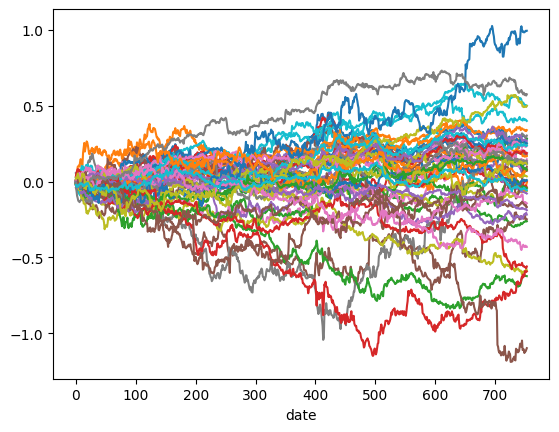

In [4]:
# The cumulative returns of the 50 stocks from the training data set over the three year period
plt.figure(figsize=(10, 6))
X_train.T.cumsum().plot(legend=False)
plt.show()

<Figure size 1000x600 with 0 Axes>

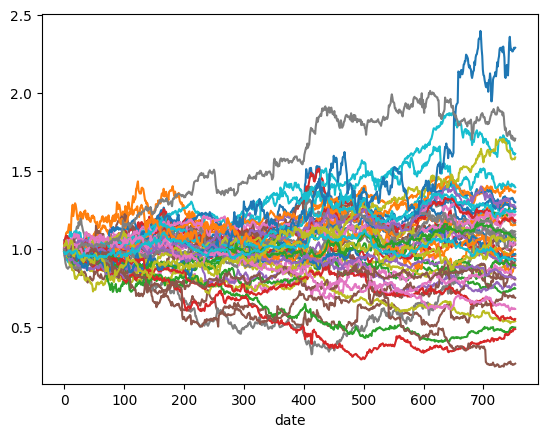

In [5]:
plt.figure(figsize=(10, 6))
(1.0+X_train.T).cumprod().plot(legend=False)
plt.show()

##### A useful data representation:

To speed up upcoming computations, we reshape the data  into a DataFrame with index (date, stock) and columns the lagged return values of the stock at time "date-1, ..., date-250".

In [6]:
X_train_reshape = pd.concat([ X_train.T.shift(i+1).stack(future_stack=True) for i in range(250) ], axis=1).dropna()
X_train_reshape.columns = pd.RangeIndex(start=1, stop=251, name="timeLag")

In [7]:
X_train_reshape.tail()

timeLag             1         2         3         4         5         6    \
date stocksID                                                               
753  45        0.009786 -0.001861  0.012294 -0.023981  0.004069  0.000148   
     46       -0.008842  0.003698  0.005138 -0.004295 -0.010509  0.010230   
     47       -0.008607  0.006122 -0.007828 -0.008224  0.011357 -0.012855   
     48       -0.007519  0.001956  0.001903  0.001535  0.000695  0.004107   
     49       -0.002816 -0.002696 -0.007145 -0.001814  0.004331  0.005457   

timeLag             7         8         9         10   ...       241  \
date stocksID                                          ...             
753  45       -0.062300  0.040002 -0.003475 -0.016284  ...  0.003808   
     46        0.006846  0.017514 -0.010796 -0.026356  ... -0.012077   
     47        0.000346 -0.016681  0.008247 -0.002723  ...  0.007291   
     48       -0.011879  0.000526  0.003178 -0.010654  ...  0.010960   
     49        0.000633 -0.005819  0.007592 -0.002003  ... -0.024003   

timeLag             242       243       244       245       246       247  \
date stocksID                                                               
753  45       -0.003027  0.002522 -0.006594 -0.000489  0.054751 -0.012180   
     46       -0.002215  0.027569  0.021476  0.003874 -0.001690  0.012346   
     47        0.000369  0.000962 -0.005902  0.001067  0.013055  0.015432   
     48       -0.012003 -0.001969  0.030976 -0.000712  0.009795 -0.006842   
     49        0.001416  0.003348 -0.003685 -0.002267 -0.006733  0.000575   

timeLag             248       249       250  
date stocksID                                
753  45        0.019142 -0.023184 -0.001315  
     46        0.007502  0.011425 -0.001580  
     47        0.023533 -0.022811 -0.001053  
     48        0.000464  0.015894 -0.003321  
     49        0.000735 -0.020917 -0.004808  

[5 rows x 250 columns]

The motivation is that, given model parameters 'A' and 'beta', the associated predictions for Y_train are simply given by **Ypred = ( X_train_reshape @ A @ beta ).unstack().T**

# The prediction model

## Stiefel matrices

##### Example 1: autoregressive model AR(F)

In [8]:
def autoRegA(D=250, F=10):

    A = np.zeros((D,F))
    for i in range(F):
        A[i,i] = 1

    return A

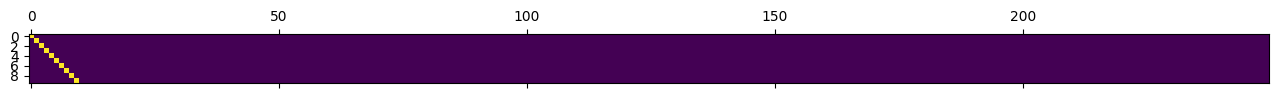

In [9]:
A = autoRegA()
plt.matshow(A.T)
plt.show()

In [10]:
A.shape

(250, 10)

##### Example 2: uniformly random Stiefel matrix A

In [11]:
def randomA(D=250, F=10):

    M = np.random.randn(D,F)
    randomStiefel = np.linalg.qr(M)[0] # Apply Gram-Schmidt algorithm to the columns of M

    return randomStiefel

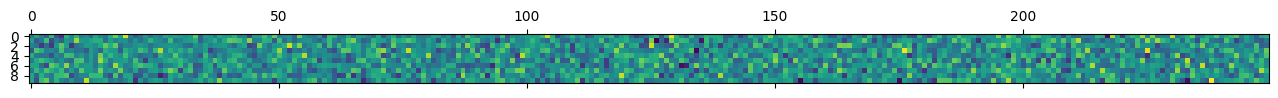

In [12]:
A = randomA()
plt.matshow(A.T)
plt.show()

In [13]:
# to check the orthonormality constraints as in the metric:

def checkOrthonormality(A):

    bool = True
    D, F = A.shape
    Error = pd.DataFrame(A.T @ A - np.eye(F)).abs()

    if any(Error.unstack() > 1e-6):
        bool = False

    return bool

In [14]:
checkOrthonormality(A)

True

## Beta parameters

##### Example 1: "keep the $m$ first factor only" 

In [15]:
def firstBeta(m=1, F=10):

    beta = np.zeros(F)
    beta[:m] = 1

    return beta

##### Example 2: given a Stiefel matrix A, return the beta with minimal mean square prediction error on the training data set

In [16]:
def fitBeta(A):

    predictors = X_train_reshape @ A # the dataframe of the 10 factors created from A with the (date, stock) in index
    targets = Y_train.T.stack()
    beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets

    return beta.to_numpy()

## Metric on the training data set

The function **metric_train** below computes the *in sample* version of the metric for parameters 'A' and 'beta', using the accessible data sets 'X_train' and 'Y_train'. 

The true metric of the challenge is defined the same way except that we use the hidden data sets 'X_test' and 'Y_test' instead of 'X_train' and 'Y_train' (recall the latter contain the returns of 50 *other* stocks from the same stock market and on the *same* time period). 

In [17]:
def metric_train(A, beta):

    if not checkOrthonormality(A):
        return -1.0

    Ypred = (X_train_reshape @ A @ beta).unstack().T
    Ytrue = Y_train

    Ytrue = Ytrue.div(np.sqrt((Ytrue**2).sum()), 1)
    Ypred = Ypred.div(np.sqrt((Ypred**2).sum()), 1)

    meanOverlap = (Ytrue * Ypred).sum().mean()

    return  meanOverlap

# Examples

##### Test 1: The autoregressive model AR(10)
$$
S_{t+1} := \sum_{\ell=1}^{10} \beta_\ell R_{t+1-\ell}
$$
where the $\beta_\ell$'s are fitted by minimizing the mean square prediction error on the training data set. 

In [18]:
A = autoRegA()
beta = fitBeta(A)

metric_train(A, beta) # public metric: 0.01282

0.024027990946887557

##### Test 2: The two factor model using '5-day returns' and 'momentum'
This model is suggested in the description of the challenge and reads
$$
S_{t+1} := \beta_1 \,R_t^{(5)} + \beta_2 \,R_{t-20}^{(230)},\qquad \text{ with }\quad R_t^{(m)}:= \frac1{\sqrt{m}}\sum_{k=1}^{m} R_{t+1-k},
$$
where we find the parameters $\beta_1$ and $\beta_2$ by minimizing the mean square prediction error on the training data set.  

*NB: the construction below actually shows how a model with $F\leq 10$ factors be recasted into the framework of the challenge.*

In [19]:
# Step 1: Create a 250x10 matrix A with the two first columns representing the factors of interest

A = np.zeros((250,10))

A[0:5, 0] = 1/np.sqrt(5) # 5-day return factor
A[20:250, 1] = 1/np.sqrt(230) # momentum factor

# Step 2: Fill the remaining columns of A with random orthonormal vectors, that are orthogonal to the two first columns

orthoProj = np.eye(250) - np.outer(A[:, 0], A[:, 0]) - np.outer(A[:, 1], A[:, 1]) # projection matrix on the orthogonal to the span of A[:,0] and A[:,1]
A_remaining_columns = orthoProj @ np.random.randn(250, 8) # sample random vectors in the space orthogonal to the first two columns of A
A_remaining_columns = np.linalg.qr(A_remaining_columns)[0] # orthonormalize these vectors with Gram-Schmidt algorithm
A[:, 2:] = A_remaining_columns

# Step 3: Compute the mean square optimal beta_1, beta_2 and then complete the vector beta with zeros

predictors = X_train_reshape @ A[:, :2]
targets = Y_train.T.stack()
beta = np.linalg.inv(predictors.T @ predictors) @ predictors.T @ targets
beta = np.hstack([beta, np.zeros(8)])


metric_train(A, beta) # public metric: 0.01787

0.019538512062321062

# The benchmark

This the code for the benchmark provided in the challenge description. 

In [21]:
Niter = 1000
maxMetric = -1

np.random.seed(1234)

for iteration in range(Niter):

    # Generate a uniform random Stiefel matric A and fit beta with minimal mean square prediction error on the training data set

    A = randomA()
    beta = fitBeta(A)

    # compute the metric on the training set and keep the best result

    m = metric_train(A, beta)

    if m > maxMetric:
        print(iteration, 'metric_train:', m)

        maxMetric = m
        A_QRT = A
        beta_QRT = beta

0 metric_train: 0.023313469330359764
1 metric_train: 0.03319696206337413
3 metric_train: 0.0353020486076357
7 metric_train: 0.03999544914662606
67 metric_train: 0.0435936893692612
138 metric_train: 0.04433262132928289
496 metric_train: 0.04441416345796451
675 metric_train: 0.04578782187329136


In [22]:
metric_train(A_QRT, beta_QRT) # public metric: 0.03535

0.04578782187329136

In [20]:
# this generates a vector of size 250
vector = np.linalg.inv(X_train_reshape.T @ X_train_reshape) @ X_train_reshape.T @ Y_train.T.stack()

In [21]:
## same result as below
vec = vector.values.reshape(-1,1)
cov = vec @ vec.T
test_U, test_S, test_Vt = np.linalg.svd(cov, full_matrices=True)
mybeta_1 = test_U[:,0:10].T @ vec.reshape(-1)
metric_train(test_U[:,0:10], test_U[:,0:10].T @ vec)

0.13319045394479695

In [22]:
test_U.shape

(250, 250)

In [23]:
test_Vt.shape

(250, 250)

In [24]:
test_U[:,0][0:10]

array([-0.02197716,  0.03937637,  0.1241485 ,  0.03402925, -0.06100372,
       -0.04169991, -0.10111748, -0.01871611,  0.01200242, -0.06538128])

In [26]:
test_Vt[0][0:10]

array([-0.02197716,  0.03937637,  0.1241485 ,  0.03402925, -0.06100372,
       -0.04169991, -0.10111748, -0.01871611,  0.01200242, -0.06538128])

In [119]:
## second approach
U, S, Vt = np.linalg.svd(vector.values.reshape(-1, 1), full_matrices=True)
subset = U[:, :10]
mybeta = subset.T @ vector.values
metric_train(subset, mybeta)

0.13319045394479698

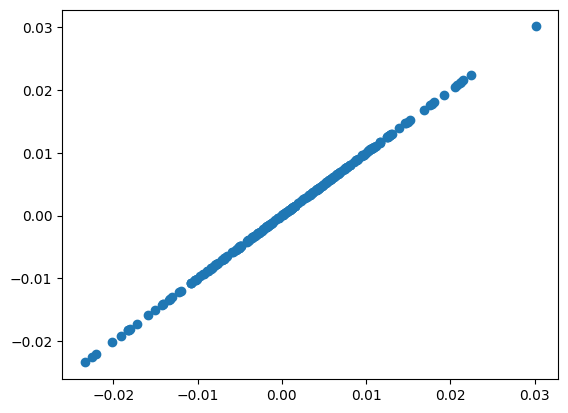

In [140]:
plt.scatter(vector.values, test_U[:,0:2] @ mybeta_1[0:2])
plt.show()

In [ ]:
factor_0 = X_train_reshape @ test_U[:,0]
factor_1 = X_train_reshape @ test_U[:,1]
factor_2 = X_train_reshape @ test_U[:,2]

factor_0 = factor_0.unstack().T
factor_1 = factor_1.unstack().T
factor_2 = factor_2.unstack().T

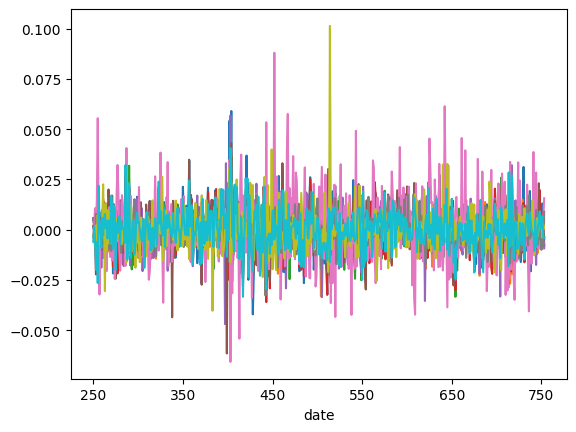

In [121]:
Y_train.iloc[0:10].T.plot(legend=False)
plt.show()

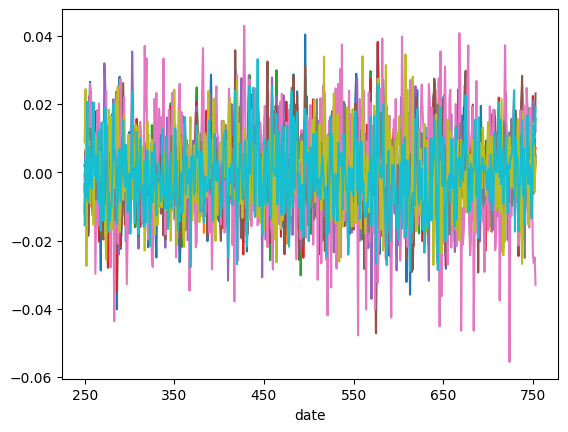

In [124]:
factor_0.iloc[0:10].T.plot(legend=False)
plt.show()

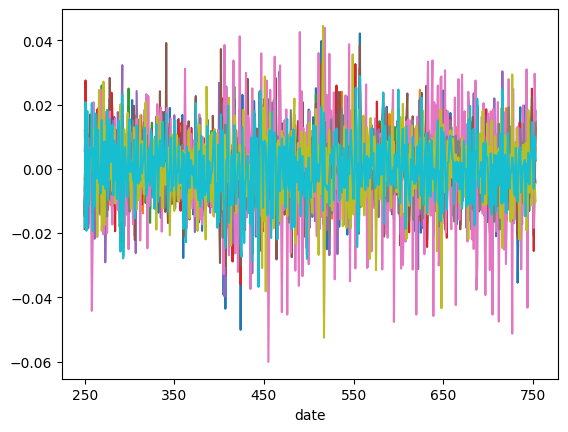

In [126]:
factor_1.iloc[0:10].T.plot(legend=False)
plt.show()

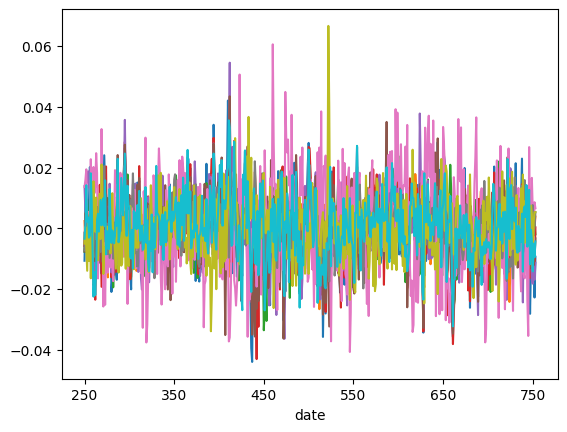

In [125]:
factor_2.iloc[0:10].T.plot(legend=False)
plt.show()

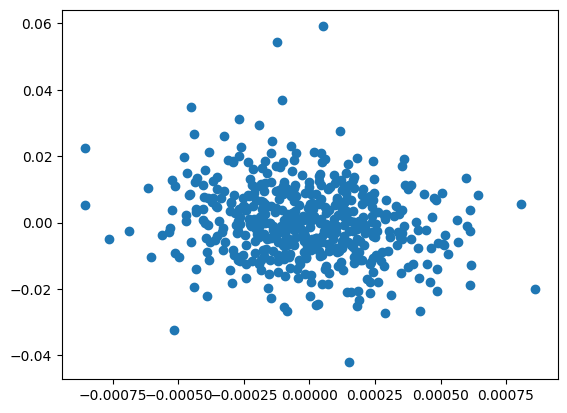

In [123]:
plt.scatter(factor_0.iloc[0].values * test_S[0], Y_train.iloc[0].values)
plt.show()

# Postprocessing

## From $(A, \beta)$ to the output csv format

In [37]:
def parametersTransform(A, beta, D=250, F=10):

    if A.shape != (D, F):
        print('A has not the good shape')
        return

    if beta.shape[0] != F:
        print('beta has not the good shape')
        return

    output = np.hstack( (np.hstack([A.T, beta.reshape((F, 1))])).T )

    return output

In [38]:
# # random submission example
# np.random.seed(1234)

# A = randomA()
# beta = np.random.rand(10)

# # from output to csv file...
# output = parametersTransform(A, beta)
# pd.DataFrame(output).to_csv(path + 'submissionExample.csv')

# # ... and back
# output_fromCsv = pd.read_csv(path + 'submissionExample.csv', index_col=0, sep=',').to_numpy()
# A = output_fromCsv[:-10].reshape((250, 10))
# beta = output_fromCsv[-10:].reshape((10))